In [1]:
# Import libraries
from __future__ import print_function


import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import psycopg2
import socket
import sys
from collections import OrderedDict

from sepsis_utils import sepsis_utils as su
from sepsis_utils import roc_utils as ru

# default colours for prettier plots
col = [[0.9047, 0.1918, 0.1988],
    [0.2941, 0.5447, 0.7494],
    [0.3718, 0.7176, 0.3612],
    [1.0000, 0.5482, 0.1000],
    [0.4550, 0.4946, 0.4722],
    [0.6859, 0.4035, 0.2412],
    [0.9718, 0.5553, 0.7741],
    [0.5313, 0.3359, 0.6523]];
marker = ['v','o','d','^','s','o','+']
ls = ['-','-','-','-','-','s','--','--']
%matplotlib inline

import colorsys
def gg_color_hue(n):
    hues = np.linspace(15, 375, n)
    hsv_tuples = [(x*1.0/360.0, 0.5, 0.8) for x in hues]
    rgb_tuples = map(lambda x: colorsys.hsv_to_rgb(*x), hsv_tuples)
    return rgb_tuples

plt.style.use('ggplot')

font = {'size'   : 20}

matplotlib.rc('font', **font)

In [2]:
hostname=socket.gethostname()

if hostname=='alistair-pc70':
    sqluser = 'alistairewj'
else:
    sqluser = 'postgres'

dbname = 'mimic'
schema_name = 'mimiciii'
query_schema = 'SET search_path to public,' + schema_name + ';'

In [3]:
# Connect to local postgres version of mimic
con = psycopg2.connect(dbname=dbname, user=sqluser)

In [4]:
# exclusion criteria:
#   - less than 16 years old
#   - never have any chartevents data (i.e. likely administrative error)
#   - not cardiac surgery
#   - suspected of infection
#   - first ICU stay

query = query_schema + "select * from sepsis3_cohort"

co = pd.read_sql_query(query,con)
co.head().T

,0,1,2,3,4
hadm_id,152234,163557,189514,129310,129607
icustay_id,200001,200003,200006,200007,200009
intime,2181-11-25 19:06:12,2199-08-02 19:50:04,2159-09-03 11:28:14,2109-02-17 10:03:37,2189-11-30 10:34:32
outtime,2181-11-28 20:59:25,2199-08-08 17:09:18,2159-09-04 19:08:10,2109-02-18 17:03:12,2189-12-02 14:17:37
age,61.0499,48.294,54.071,43.3439,47.5548
gender,F,M,M,M,F
ethnicity,ASIAN - ASIAN INDIAN,WHITE,OTHER,WHITE,WHITE
first_service,MED,SURG,MED,CMED,CSURG
dbsource,metavision,carevue,carevue,carevue,carevue
suspected_of_infection,1,1,1,0,0


In [5]:
# print out the exclusions
print('Cohort - initial size: {} ICU stays'.format(co.shape[0]))
idxRem = np.zeros(co.shape[0])
for c in co.columns:
    if c.startswith('exclusion_'):
        print('  {:5g} ({:2.2f}%) - {}'.format(np.sum(co[c]),np.mean(co[c])*100.0, c))
        idxRem[co[c].values==1] = 1
        
print('Final cohort size: {} ICU stays ({:2.2f}%).'.format(co.shape[0] - np.sum(idxRem), (1-np.mean(idxRem))*100.0))

Cohort - initial size: 61532 ICU stays
  15056 (24.47%) - exclusion_secondarystay
   8109 (13.18%) - exclusion_nonadult
   7343 (11.93%) - exclusion_csurg
  37912 (61.61%) - exclusion_carevue
   7343 (11.93%) - exclusion_early_suspicion
   3914 (6.36%) - exclusion_late_suspicion
    491 (0.80%) - exclusion_bad_data
Final cohort size: 11791.0 ICU stays (19.16%).


In [6]:
# print out the exclusions *SEQUENTIALLY* - i.e. if already excluded, don't re-print
print('Cohort - initial size: {} ICU stays'.format(co.shape[0]))

COL_REM = ['exclusion_nonadult', 'exclusion_secondarystay',
           'exclusion_csurg','exclusion_carevue',
           'exclusion_early_suspicion', 'exclusion_late_suspicion', 'exclusion_bad_data']

idxRem = np.zeros(co.shape[0])
for c in COL_REM:
    N_REM = np.sum( (idxRem == 0) & (co[c].values==1) )
    print('  {:5g} ({:2.2f}%) - {}'.format(N_REM,N_REM*100.0/co.shape[0], c))
    idxRem[co[c].values==1] = 1
        
print('Final non-suspected cohort size: {:g} ICU stays ({:2.2f}%).'.format(co.shape[0] - np.sum(idxRem), (1-np.mean(idxRem))*100.0))

print()
# define idxRem to exclude non-metavision admissions initially
print('=======================')
print('=== METAVISION ONLY ===')
print('=======================')
print()

idxRem = co['dbsource']!='metavision'
N = np.sum(~idxRem)
N_IGNORE = np.sum(idxRem)

# print out the exclusions *SEQUENTIALLY* - i.e. if already excluded, don't re-print
print('Cohort - initial size: {} ICU stays'.format(N))

for c in COL_REM:
    N_REM = np.sum( (idxRem == 0) & (co[c].values==1) )
    print('  {:5g} ({:2.2f}%) - {}'.format(N_REM,N_REM*100.0/N, c))
    idxRem[co[c].values==1] = True
        
print('Final non-suspected cohort size: {} ICU stays ({:2.2f}%).'.format(
        np.sum(~idxRem), np.sum(~idxRem)*100.0/N))
print('')

c='suspected_of_infection'
N_REM = np.sum( (~idxRem) & (co[c].values==1) )
print('  {:5g} ({:2.2f}%) - {}'.format(N_REM, N_REM*100.0/ np.sum(~idxRem), c))

c='suspected_of_infection_mv'
N_REM = np.sum( (~idxRem) & (co[c].values==1) )
print('  {:5g} ({:2.2f}%) - {}'.format(N_REM, N_REM*100.0/ np.sum(~idxRem), c))

c='suspected_of_infection_poe'
N_REM = np.sum( (~idxRem) & (co[c].values==1) )
print('  {:5g} ({:2.2f}%) - {}'.format(N_REM, N_REM*100.0/ np.sum(~idxRem), c))

Cohort - initial size: 61532 ICU stays
   8109 (13.18%) - exclusion_nonadult
  14826 (24.09%) - exclusion_secondarystay
   5905 (9.60%) - exclusion_csurg
  18909 (30.73%) - exclusion_carevue
   1250 (2.03%) - exclusion_early_suspicion
    724 (1.18%) - exclusion_late_suspicion
     18 (0.03%) - exclusion_bad_data
Final non-suspected cohort size: 11791 ICU stays (19.16%).

=== METAVISION ONLY ===

Cohort - initial size: 23620 ICU stays
      3 (0.01%) - exclusion_nonadult
   7536 (31.91%) - exclusion_secondarystay
   2298 (9.73%) - exclusion_csurg
      0 (0.00%) - exclusion_carevue
   1250 (5.29%) - exclusion_early_suspicion
    724 (3.07%) - exclusion_late_suspicion
     18 (0.08%) - exclusion_bad_data
Final non-suspected cohort size: 11791 ICU stays (49.92%).

  10912 (92.55%) - suspected_of_infection
   5671 (48.10%) - suspected_of_infection_mv
   7061 (59.88%) - suspected_of_infection_poe


In [7]:
# load in final dataset (already has exclusion criteria applied)
query = query_schema + "select * from sepsis3"

df = pd.read_sql_query(query,con)
df.columns

Index([u'icustay_id', u'hadm_id', u'intime', u'outtime', u'dbsource',
       u'suspected_infection_time', u'suspected_infection_time_days',
       u'specimen', u'positiveculture', u'suspected_infection_time_mv',
       u'suspected_infection_time_mv_days', u'specimen_mv',
       u'positiveculture_mv', u'suspected_infection_time_poe',
       u'suspected_infection_time_poe_days', u'specimen_poe',
       u'positiveculture_poe', u'antibiotic_time_poe',
       u'suspected_infection_time_d1poe',
       u'suspected_infection_time_d1poe_days', u'specimen_d1poe',
       u'positiveculture_d1poe', u'suspected_of_infection_piv',
       u'suspected_infection_time_piv_days', u'specimen_piv',
       u'positiveculture_piv', u'age', u'gender', u'is_male', u'ethnicity',
       u'race_white', u'race_black', u'race_hispanic', u'race_other',
       u'metastatic_cancer', u'diabetes', u'height', u'weight', u'bmi',
       u'first_service', u'hospital_expire_flag', u'thirtyday_expire_flag',
       u'icu_los', u

We have: ICU intime/outtime, suspected infection time, whether the microbiology culture was positive, some demographics, comorbidities, outcomes, and the severity scores. 

The severity scores are extracted at a [0, 24] hour window centered around ICU admission - except labs have an extended [-6, 24] hour window (i.e. 'sofa' is extracted in this way).

# Time of suspected infection

Suspected infection is defined as the first time of a microbiology culture within 24 hours of ICU admission (i.e. before or after).

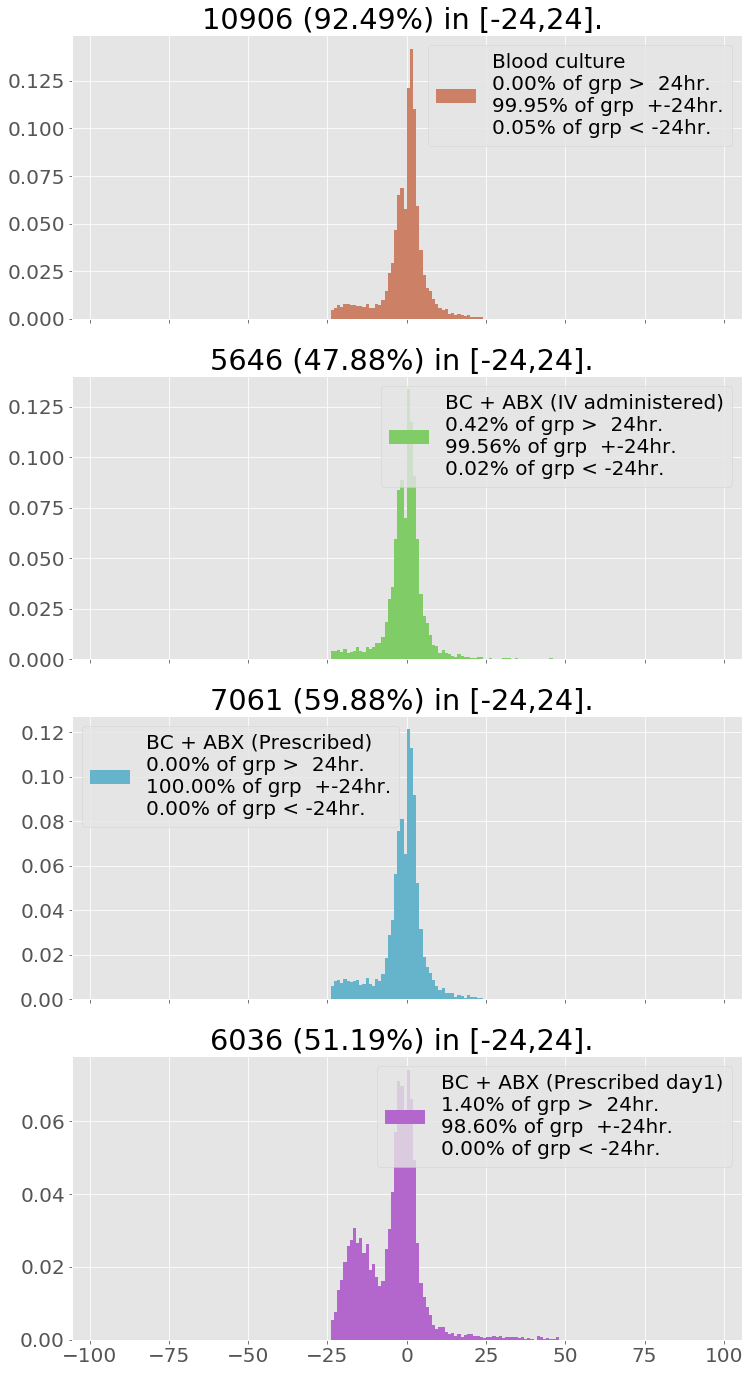

In [8]:
# distribution of time of infection
N_HR = 96
xi = np.linspace(-N_HR, N_HR, N_HR*2+1)
col = gg_color_hue(5)

labels = OrderedDict([['suspected_infection_time', 'Blood culture'],
          ['suspected_infection_time_mv', 'BC + ABX (IV administered)'],
          ['suspected_infection_time_poe', 'BC + ABX (Prescribed)'],
          ['suspected_infection_time_d1poe', 'BC + ABX (Prescribed day1)']])

f, axarr = plt.subplots(len(labels), sharex = True, figsize=[12,24])
for i, c in enumerate(labels):
    idxKeep = ~df[c].isnull()
    tmp = (df.loc[idxKeep, c] - df.loc[idxKeep,'intime']).values / np.timedelta64(1, 'h')
    N_firstday = sum( (tmp>-24) & (tmp<24) )
    
    lbl_str = labels[c]
    lbl_str += '\n' + '{:2.2f}% of grp >  24hr.'.format(sum(tmp>24)*100.0 / np.sum(idxKeep))
    lbl_str += '\n' + '{:2.2f}% of grp  +-24hr.'.format(sum((tmp>-24) & (tmp<24))*100.0 / np.sum(idxKeep))
    lbl_str += '\n' + '{:2.2f}% of grp < -24hr.'.format(sum(tmp<-24)*100.0 / np.sum(idxKeep))
    axarr[i].hist( tmp, bins=xi, label=lbl_str, color=col[i], normed=True )
    axarr[i].set_title('{} ({:2.2f}%) in [-24,24]. '.format(
            N_firstday, N_firstday*100.0 / df.shape[0]))
    axarr[i].legend()
    
plt.show()

Note that because time is not always available with the microbiology acquisition, some patients appeart to have microbiology < 24 hours before admission. 

In [9]:
# determine how many were excluded for reasons other than suspicion of infection
idxRem = np.zeros(df.shape[0],dtype=bool)
N = df.shape[0]



labels = OrderedDict([['suspected_infection_time', 'Blood culture'],
          ['suspected_infection_time_mv', 'BC + ABX (IV administered)'],
          ['suspected_infection_time_poe', 'BC + ABX (Prescribed)'],
          ['suspected_infection_time_d1poe', 'BC + ABX (Prescribed at most 1 day before ICU admit)']])

print('Proportion among patients')
# report on % with suspicion of infection
print('Of the total {:g} stays...'.format(N))
for i, c in enumerate(labels):
    print('\t{:5g} ({:2.2f}%) - {}'.format(
            np.sum(~df.loc[~idxRem,c].isnull()),
            np.sum(~df.loc[~idxRem,c].isnull()).astype(float)*100.0 / N, labels[c]))

Proportion among patients
Of the total 11791 stays...
	10912 (92.55%) - Blood culture
	 5671 (48.10%) - BC + ABX (IV administered)
	 7061 (59.88%) - BC + ABX (Prescribed)
	 6122 (51.92%) - BC + ABX (Prescribed at most 1 day before ICU admit)


We can see that most patients are suspected of infection either before, or at the time of their ICU admission. This motivates the decision to evaluate the performance of the scores at ICU admission.

# Baseline model + scores

The original paper evaluates a *baseline model* with the addition of the various severity scores. 

> To measure predictive validity, a baseline risk model was created for in-hospital mortality based on preinfection criteria using multivariable logistic regression. The baseline model included age (as a fractional polynomial), sex, race/ethnicity (black, white, or other), and the weighted Charlson comorbidity score (as fractional polynomial) as a measure of chronic comorbidities.

This baseline model includes:

* age (fractional polynomial)
* sex
* ethnicity
* Charlson comorbidities (fractional polynomial)

We will reproduce this model, with the following caveats:

1. We will build and evaluate the model on the same dataset, so our estimates are "apparent"
2. We will use Elixhauser comorbidities, not Charlson comorbidities
3. We may not have identical fractional polynomial terms (as we are rebuilding the model on our dataset)

The following code block extracts the covariates for the baseline model.

In [10]:
X_header = ['age','elixhauser_hospital','hospital_expire_flag','sepsis_angus',
            'is_male','race_black','race_other',
            'qsofa','sofa','sirs','lods']

X = df[X_header].values

# we'll write out the design matrix for the MFP model here - this is used by the R code
np.savetxt('sepsis3-design-matrix.csv', X, fmt='%4.4f',
           delimiter=',', header=','.join(X_header), comments='')

# Save the data to file

The dataframes will be loaded directly from a file, rather than the database.

The `X` data which was written to 'sepsis3-design-matrix.csv' will be used by the `print_auc_table_baseline` function to evaluate the AUROC of the scores when incorporated with the baseline model.

In [11]:
df.to_csv('sepsis3-df.csv',sep=',',index=False)

In [12]:
con.close()